In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
prices = pd.read_csv('NASDAQ Historical Data Price Only.csv',index_col='Date')

In [8]:
prices.index = pd.to_datetime(prices.index)
prices.head()

,Price
Date,
2018-01-26,7505.77
2018-01-25,7411.16
2018-01-24,7415.06
2018-01-23,7460.29
2018-01-22,7408.03


** Plotting out the NASDAQ price data **

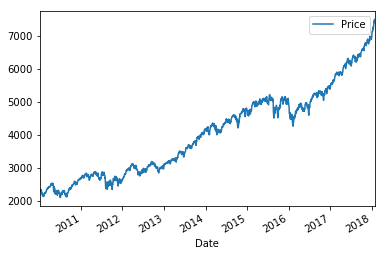

In [9]:
prices.plot()

___

### Train Test Split


In [10]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2031 entries, 2018-01-26 to 2010-01-04
Data columns (total 1 columns):
Price    2031 non-null float64
dtypes: float64(1)
memory usage: 31.7 KB


In [11]:
train_set = prices.tail(2000)

In [12]:
test_set = prices.head(31)

### Scale the Data


In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
train_scaled = scaler.fit_transform(train_set)

In [16]:
test_scaled = scaler.transform(test_set)

## Batch Function


In [17]:
def next_batch(training_data,batch_size,steps):
    """
    INPUT: Data, Batch Size, Time Steps per batch
    OUTPUT: A tuple of y time series results. y[:,:-1] and y[:,1:]
    """

In [18]:
def next_batch(training_data,batch_size,steps):
    
    
    # Grab a random starting point for each batch
    rand_start = np.random.randint(0,len(training_data)-steps) 

    # Create Y data for time series in the batches
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)

    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

## Setting Up The RNN Model

In [19]:
import tensorflow as tf
tf.reset_default_graph()

### The Constants


In [20]:
# Just one feature, the time series
num_inputs = 1
# Num of steps in each batch
num_time_steps = 31
# 100 neuron layer
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1

# learning rate 
learning_rate = 0.01 
# how many iterations to go through (training steps)
num_train_iterations = 4000
# Size of the batch of data
batch_size = 1

In [21]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [22]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs, reuse=tf.get_variable_scope().reuse) 

In [23]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### Loss Function and Optimizer


In [78]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9)
train = optimizer.minimize(loss)

** Initialize the global variables **

In [79]:
init = tf.global_variables_initializer()

** Create an instance of tf.train.Saver() **

In [80]:
saver = tf.train.Saver()

### Session


In [81]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [82]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./stock_prediction_model")

0 	MSE: 0.0344583
100 	MSE: 0.0031086
200 	MSE: 0.00484149
300 	MSE: 0.00107546
400 	MSE: 0.00068948
500 	MSE: 0.000235299
600 	MSE: 0.000176826
700 	MSE: 0.00116414
800 	MSE: 9.49568e-05
900 	MSE: 0.00014012
1000 	MSE: 5.35445e-05
1100 	MSE: 5.51938e-05
1200 	MSE: 2.22684e-05
1300 	MSE: 7.1323e-05
1400 	MSE: 5.55103e-05
1500 	MSE: 3.00245e-05
1600 	MSE: 0.000178084
1700 	MSE: 5.35534e-05
1800 	MSE: 0.00011179
1900 	MSE: 5.06227e-05
2000 	MSE: 9.36297e-05
2100 	MSE: 0.00010627
2200 	MSE: 0.000173456
2300 	MSE: 6.49146e-05
2400 	MSE: 0.000197331
2500 	MSE: 5.00435e-05
2600 	MSE: 5.11937e-05
2700 	MSE: 3.42705e-05
2800 	MSE: 4.96423e-05
2900 	MSE: 0.000358287
3000 	MSE: 0.000157107
3100 	MSE: 3.06273e-05
3200 	MSE: 0.000109319
3300 	MSE: 4.46129e-05
3400 	MSE: 0.000548639
3500 	MSE: 4.35069e-05
3600 	MSE: 5.60752e-05
3700 	MSE: 0.000120626
3800 	MSE: 0.000305925
3900 	MSE: 4.95233e-05


______

# Generative Session


In [83]:
with tf.Session() as sess:
    
    # Restoring from saver
    saver.restore(sess, "./stock_prediction_model")

    train_seed = list(train_scaled[-31:])
     
    for iteration in range(31):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./stock_prediction_model


In [84]:
train_seed

[array([ 0.02790126]),
 array([ 0.02539119]),
 array([ 0.01903094]),
 array([ 0.01776139]),
 array([ 0.01163348]),
 array([ 0.01225581]),
 array([ 0.00710704]),
 array([ 0.01023323]),
 array([ 0.00697843]),
 array([ 0.02056188]),
 array([ 0.02038556]),
 array([ 0.01647316]),
 array([ 0.01152561]),
 array([ 0.01809122]),
 array([ 0.02688894]),
 array([ 0.02322132]),
 array([ 0.02468795]),
 array([ 0.02354493]),
 array([ 0.03607665]),
 array([ 0.04137685]),
 array([ 0.04742385]),
 array([ 0.04070058]),
 array([ 0.04666461]),
 array([ 0.0448308]),
 array([ 0.0395223]),
 array([ 0.04576637]),
 array([ 0.04675381]),
 array([ 0.04320236]),
 array([ 0.0434181]),
 array([ 0.04499883]),
 array([ 0.04493867]),
 0.043419123,
 0.042233676,
 0.041037992,
 0.039757773,
 0.038534284,
 0.037412807,
 0.036378115,
 0.035412595,
 0.034503043,
 0.033640921,
 0.032819688,
 0.032035038,
 0.03128396,
 0.030564412,
 0.029874519,
 0.029212296,
 0.028577462,
 0.027973339,
 0.027401984,
 0.026861012,
 0.02634833

In [85]:
results = scaler.inverse_transform(np.array(train_seed[31:]).reshape(31,1))

** Create a new column on the test_set called "Generated" and set it equal to the generated results.

In [86]:
test_set['Generated'] = results

C:\Users\Xavier\Anaconda3\envs\tfdeeplearning\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [87]:
test_set

,Price,Generated
Date,,
2018-01-26,7505.77,2301.094971
2018-01-25,7411.16,2295.380371
2018-01-24,7415.06,2289.616455
2018-01-23,7460.29,2283.445068
2018-01-22,7408.03,2277.547119
2018-01-19,7336.38,2272.141113
2018-01-18,7296.05,2267.153320
2018-01-17,7298.28,2262.499023
2018-01-16,7223.69,2258.114258


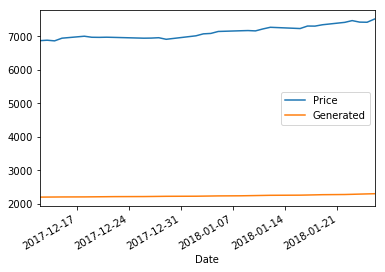

In [88]:
test_set.plot()